# **1. Install packages**
-------------------------------------------------------------------------------

In [1]:
%%capture
!pip install catboost
!pip install pingouin

# **2. Load libraries**
-------------------------------------------------------------------------------

In [2]:
# Data manipulation
#==============================================================================
import pandas as pd
pd.set_option("display.max_columns", None)
import numpy as np

# Stats
#==============================================================================
from scipy import stats
import statsmodels.api as sm
import pingouin as pg

# Data visualization
#==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns

# Data preprocessing
#===============================================================================
from sklearn.model_selection import train_test_split as tts

# Models
#===============================================================================
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import tensorflow as tf
from keras.layers import Dense, Input, Dropout
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import load_model

# Metrics
#===============================================================================
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve

# tqdm
#===============================================================================
from tqdm.auto import tqdm

# warnings
#===============================================================================
import warnings
warnings.filterwarnings("ignore")

# **3. Load data**
-------------------------------------------------------------------------------

In [3]:
data = pd.read_csv("/kaggle/input/apple-quality/apple_quality.csv")
data.head()

,A_id,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
0,0.0,-3.970049,-2.512336,5.346330,-1.012009,1.844900,0.329840,-0.491590483,good
1,1.0,-1.195217,-2.839257,3.664059,1.588232,0.853286,0.867530,-0.722809367,good
2,2.0,-0.292024,-1.351282,-1.738429,-0.342616,2.838636,-0.038033,2.621636473,bad
3,3.0,-0.657196,-2.271627,1.324874,-0.097875,3.637970,-3.413761,0.790723217,good
4,4.0,1.364217,-1.296612,-0.384658,-0.553006,3.030874,-1.303849,0.501984036,good


In [4]:
# Data set size
#================================
print(f'Rows: {data.shape[0]}')
print(f'Columns: {data.shape[1]}')

Rows: 4001
Columns: 9


In [5]:
# Dat set information
#=====================================
print("---------------------------------------------------")
print(" " * 12, "Dat set Information")
print("---------------------------------------------------")
print(data.info())

---------------------------------------------------
             Dat set Information
---------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4001 entries, 0 to 4000
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   A_id         4000 non-null   float64
 1   Size         4000 non-null   float64
 2   Weight       4000 non-null   float64
 3   Sweetness    4000 non-null   float64
 4   Crunchiness  4000 non-null   float64
 5   Juiciness    4000 non-null   float64
 6   Ripeness     4000 non-null   float64
 7   Acidity      4001 non-null   object 
 8   Quality      4000 non-null   object 
dtypes: float64(7), object(2)
memory usage: 281.4+ KB
None


# **4. EDA**
-------------------------------------------------------------------------------

In [6]:
# We eliminate the first id column since it does not add value to the analysis.
data = data.drop("A_id", axis = 1)
data.head()

,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
0,-3.970049,-2.512336,5.346330,-1.012009,1.844900,0.329840,-0.491590483,good
1,-1.195217,-2.839257,3.664059,1.588232,0.853286,0.867530,-0.722809367,good
2,-0.292024,-1.351282,-1.738429,-0.342616,2.838636,-0.038033,2.621636473,bad
3,-0.657196,-2.271627,1.324874,-0.097875,3.637970,-3.413761,0.790723217,good
4,1.364217,-1.296612,-0.384658,-0.553006,3.030874,-1.303849,0.501984036,good


In [7]:
# Convert the "Acidity" column to float type.
# This will generate a NaN value since there is a string that could not be
# convert to float type.
#===================================================
data['Acidity'] = pd.to_numeric(data['Acidity'], errors = 'coerce')

- **Duplicate rows**

In [8]:
print(f'Total duplicate rows: {data.duplicated().sum()}')

Total duplicate rows: 0


- **Missing values**

In [9]:
df_null_values = data.isnull().sum().to_frame().rename(columns = {0:'count'})
df_null_values['%'] = (df_null_values['count'] / len(data)) * 100.
df_null_values = df_null_values.sort_values('%', ascending = False)
df_null_values

,count,%
Size,1,0.024994
Weight,1,0.024994
Sweetness,1,0.024994
Crunchiness,1,0.024994
Juiciness,1,0.024994
Ripeness,1,0.024994
Acidity,1,0.024994
Quality,1,0.024994


In [10]:
# We look for where the missing values ​​are located.
#====================================================================0
data[data.isnull().any(axis = 1)]

,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
4000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# Because it's only one row, we're going to proceed to delete it.
#==========================================================================
data = data.dropna(ignore_index = True)

# We check that there are no longer missing values.
#==================================================================
data.isnull().sum()

Size           0
Weight         0
Sweetness      0
Crunchiness    0
Juiciness      0
Ripeness       0
Acidity        0
Quality        0
dtype: int64

- **Univariate Analysis**

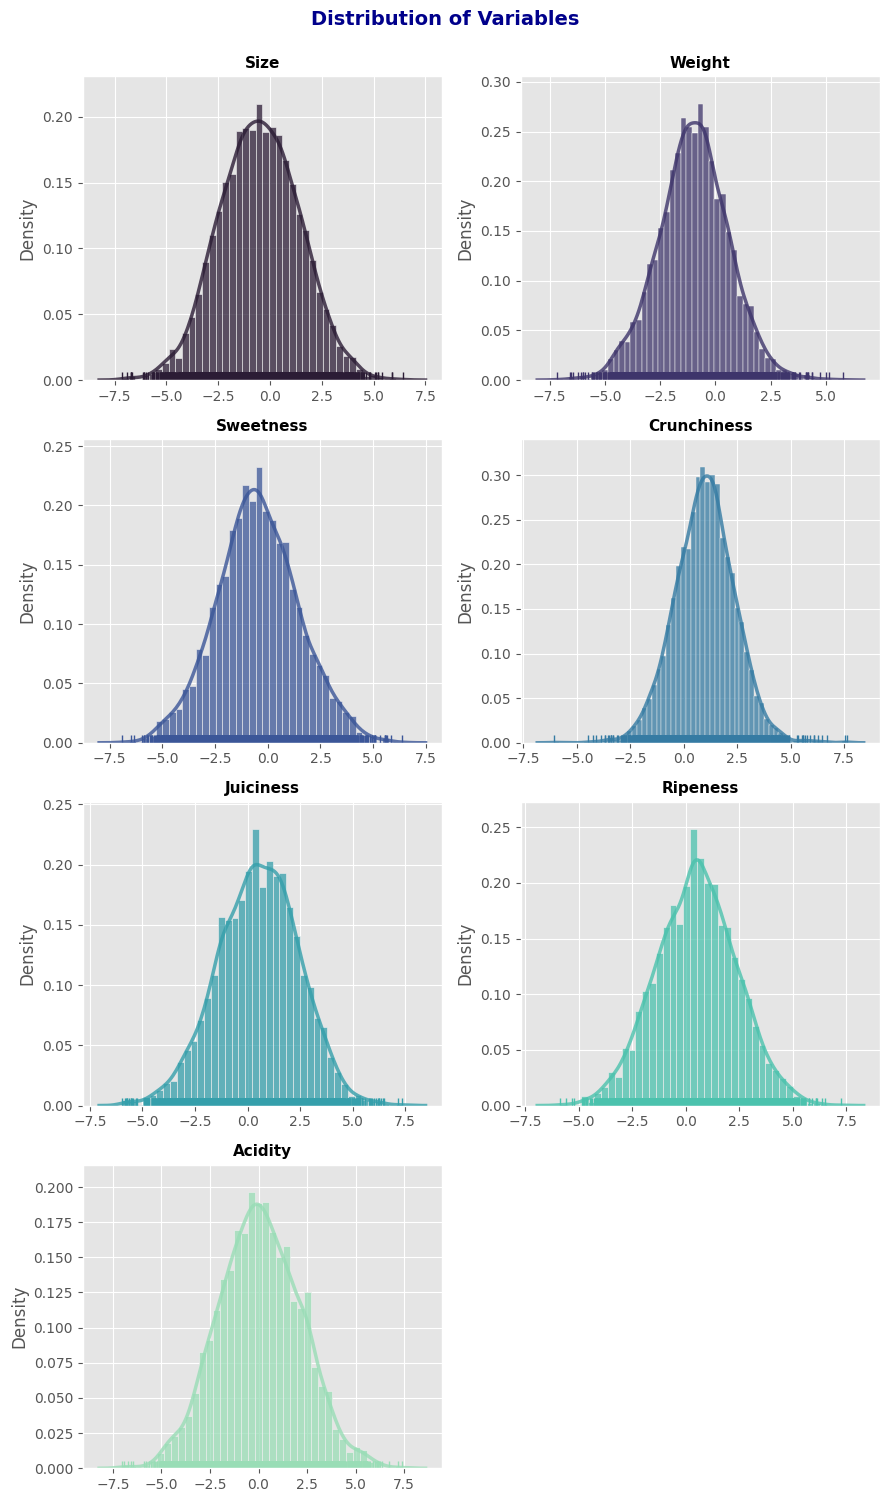

In [13]:
cols = data.columns.to_list()[:-1]
colors = sns.color_palette('mako', len(cols))

fig,axs = plt.subplots(nrows = 4, ncols = 2, figsize = (9,15))
plt.style.use("ggplot")
axs= axs.flat

for i,col in enumerate(cols):
    sns.kdeplot(data, x = col, alpha = 0.8, linewidth = 2.5, color = colors[i], ax = axs[i])
    sns.histplot(data, x = col, stat = 'density', color = colors[i], ax = axs[i])
    sns.rugplot(data, x = col, color = colors[i], ax = axs[i])
    axs[i].set_xlabel("")
    axs[i].set_title(col, fontsize = 11, fontweight = "bold", color = "black")
    
fig.suptitle("Distribution of Variables", fontsize = 14, fontweight = "bold", color = "darkblue", y = 0.998)
fig.delaxes(ax = axs[7])
fig.tight_layout()
fig.show()

In [14]:
# Descriptive statistics
#===============================================
data[cols].describe().T

,count,mean,std,min,25%,50%,75%,max
Size,4000.0,-0.503015,1.928059,-7.151703,-1.816765,-0.513703,0.805526,6.406367
Weight,4000.0,-0.989547,1.602507,-7.149848,-2.011770,-0.984736,0.030976,5.790714
Sweetness,4000.0,-0.470479,1.943441,-6.894485,-1.738425,-0.504758,0.801922,6.374916
Crunchiness,4000.0,0.985478,1.402757,-6.055058,0.062764,0.998249,1.894234,7.619852
Juiciness,4000.0,0.512118,1.930286,-5.961897,-0.801286,0.534219,1.835976,7.364403
Ripeness,4000.0,0.498277,1.874427,-5.864599,-0.771677,0.503445,1.766212,7.237837
Acidity,4000.0,0.076877,2.110270,-7.010538,-1.377424,0.022609,1.510493,7.404736


In [15]:
print('-----------------------------------------------------')
print(' '*10, 'Kurtosis and Skewness')
print('-----------------------------------------------------')
for col in cols:
    print(f'* {col}: Kurtosis: {stats.kurtosis(data[col]):.4f}| Skewness: {stats.skew(data[col]):.4f}')


-----------------------------------------------------
           Kurtosis and Skewness
-----------------------------------------------------
* Size: Kurtosis: -0.0847| Skewness: -0.0024
* Weight: Kurtosis: 0.3571| Skewness: 0.0031
* Sweetness: Kurtosis: 0.0130| Skewness: 0.0838
* Crunchiness: Kurtosis: 0.7196| Skewness: 0.0002
* Juiciness: Kurtosis: 0.0272| Skewness: -0.1134
* Ripeness: Kurtosis: -0.0733| Skewness: -0.0088
* Acidity: Kurtosis: -0.0948| Skewness: 0.0558


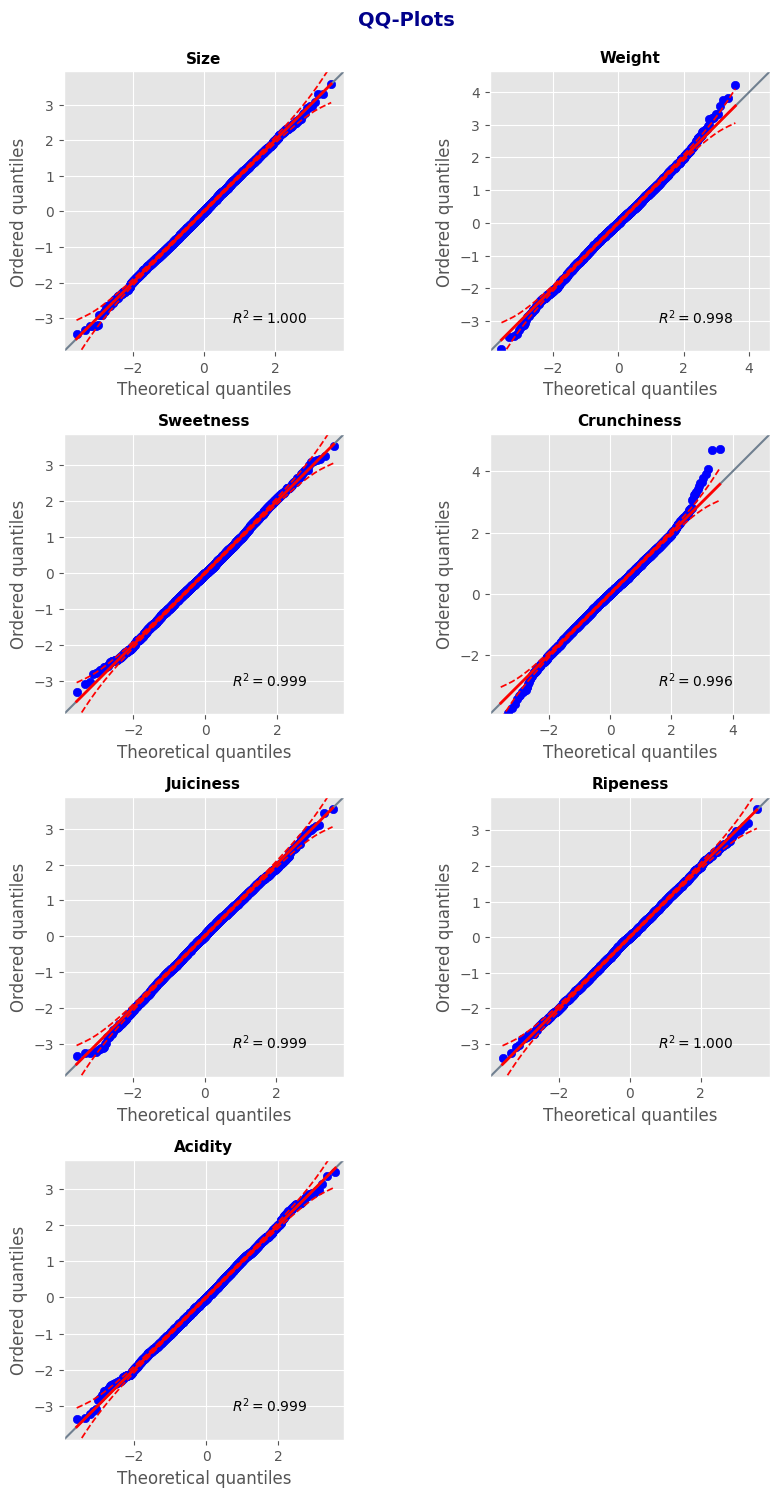

In [16]:
fig,axs = plt.subplots(nrows = 4, ncols = 2, figsize = (9, 15))
axs = axs.flat

for i,col in enumerate(cols):
    pg.qqplot(data[col],  ax = axs[i])
    axs[i].set_title(col, fontsize = 11, fontweight = "bold", color = "black")
    
fig.suptitle("QQ-Plots", fontsize = 14, fontweight = "bold", color = "darkblue", y = 0.995)
fig.delaxes(ax = axs[7])
fig.tight_layout()
fig.show()

**Normality test**

In [17]:
def normality_test(name:str):
    p_value = stats.normaltest(data[name])[1]
    decision = "No Normal Distribution" if p_value < 0.05 else "Normal Distribution"
    return decision

In [18]:
print("--------------------------------------------")
print(" "*5, "Normal Test: D' Agostino")
print("--------------------------------------------")
for col in cols:
    print(f'* {col}: {normality_test(col)}')

--------------------------------------------
      Normal Test: D' Agostino
--------------------------------------------
* Size: Normal Distribution
* Weight: No Normal Distribution
* Sweetness: Normal Distribution
* Crunchiness: No Normal Distribution
* Juiciness: No Normal Distribution
* Ripeness: Normal Distribution
* Acidity: Normal Distribution


According to the normality test, we have only 4 variables that come from a population with a Normal Distribution and they are the following:
- **Size**
- **Sweetness**
- **Ripeness**
- **Acidity**

Let's look at the class distribution of the target variable.

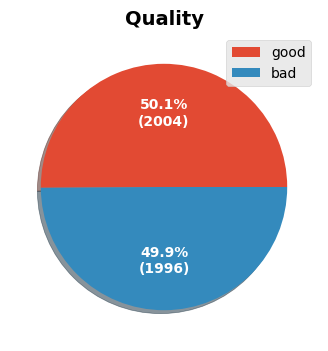

In [21]:
df_quality = data['Quality'].value_counts().to_frame()
labels = df_quality.index.to_list()
values = df_quality.iloc[:,0].to_list()

def autopct_fun(abs_values):
    gen = iter(abs_values)
    return lambda pct: f"{pct:.1f}%\n({next(gen)})"

fig,ax = plt.subplots(figsize = (4,4))
ax.pie(x = values, labels = labels, autopct=autopct_fun(values), shadow = True, textprops = {'color':'white', 'fontsize':10, 'fontweight':'bold'})
ax.legend(labels)
ax.set_title("Quality", fontsize = 14, fontweight = "bold", color = "black")
fig.show()

We see that the class distribution is balanced, so we will use **accuracy** as a metric.

- **Bivariate Analysis**

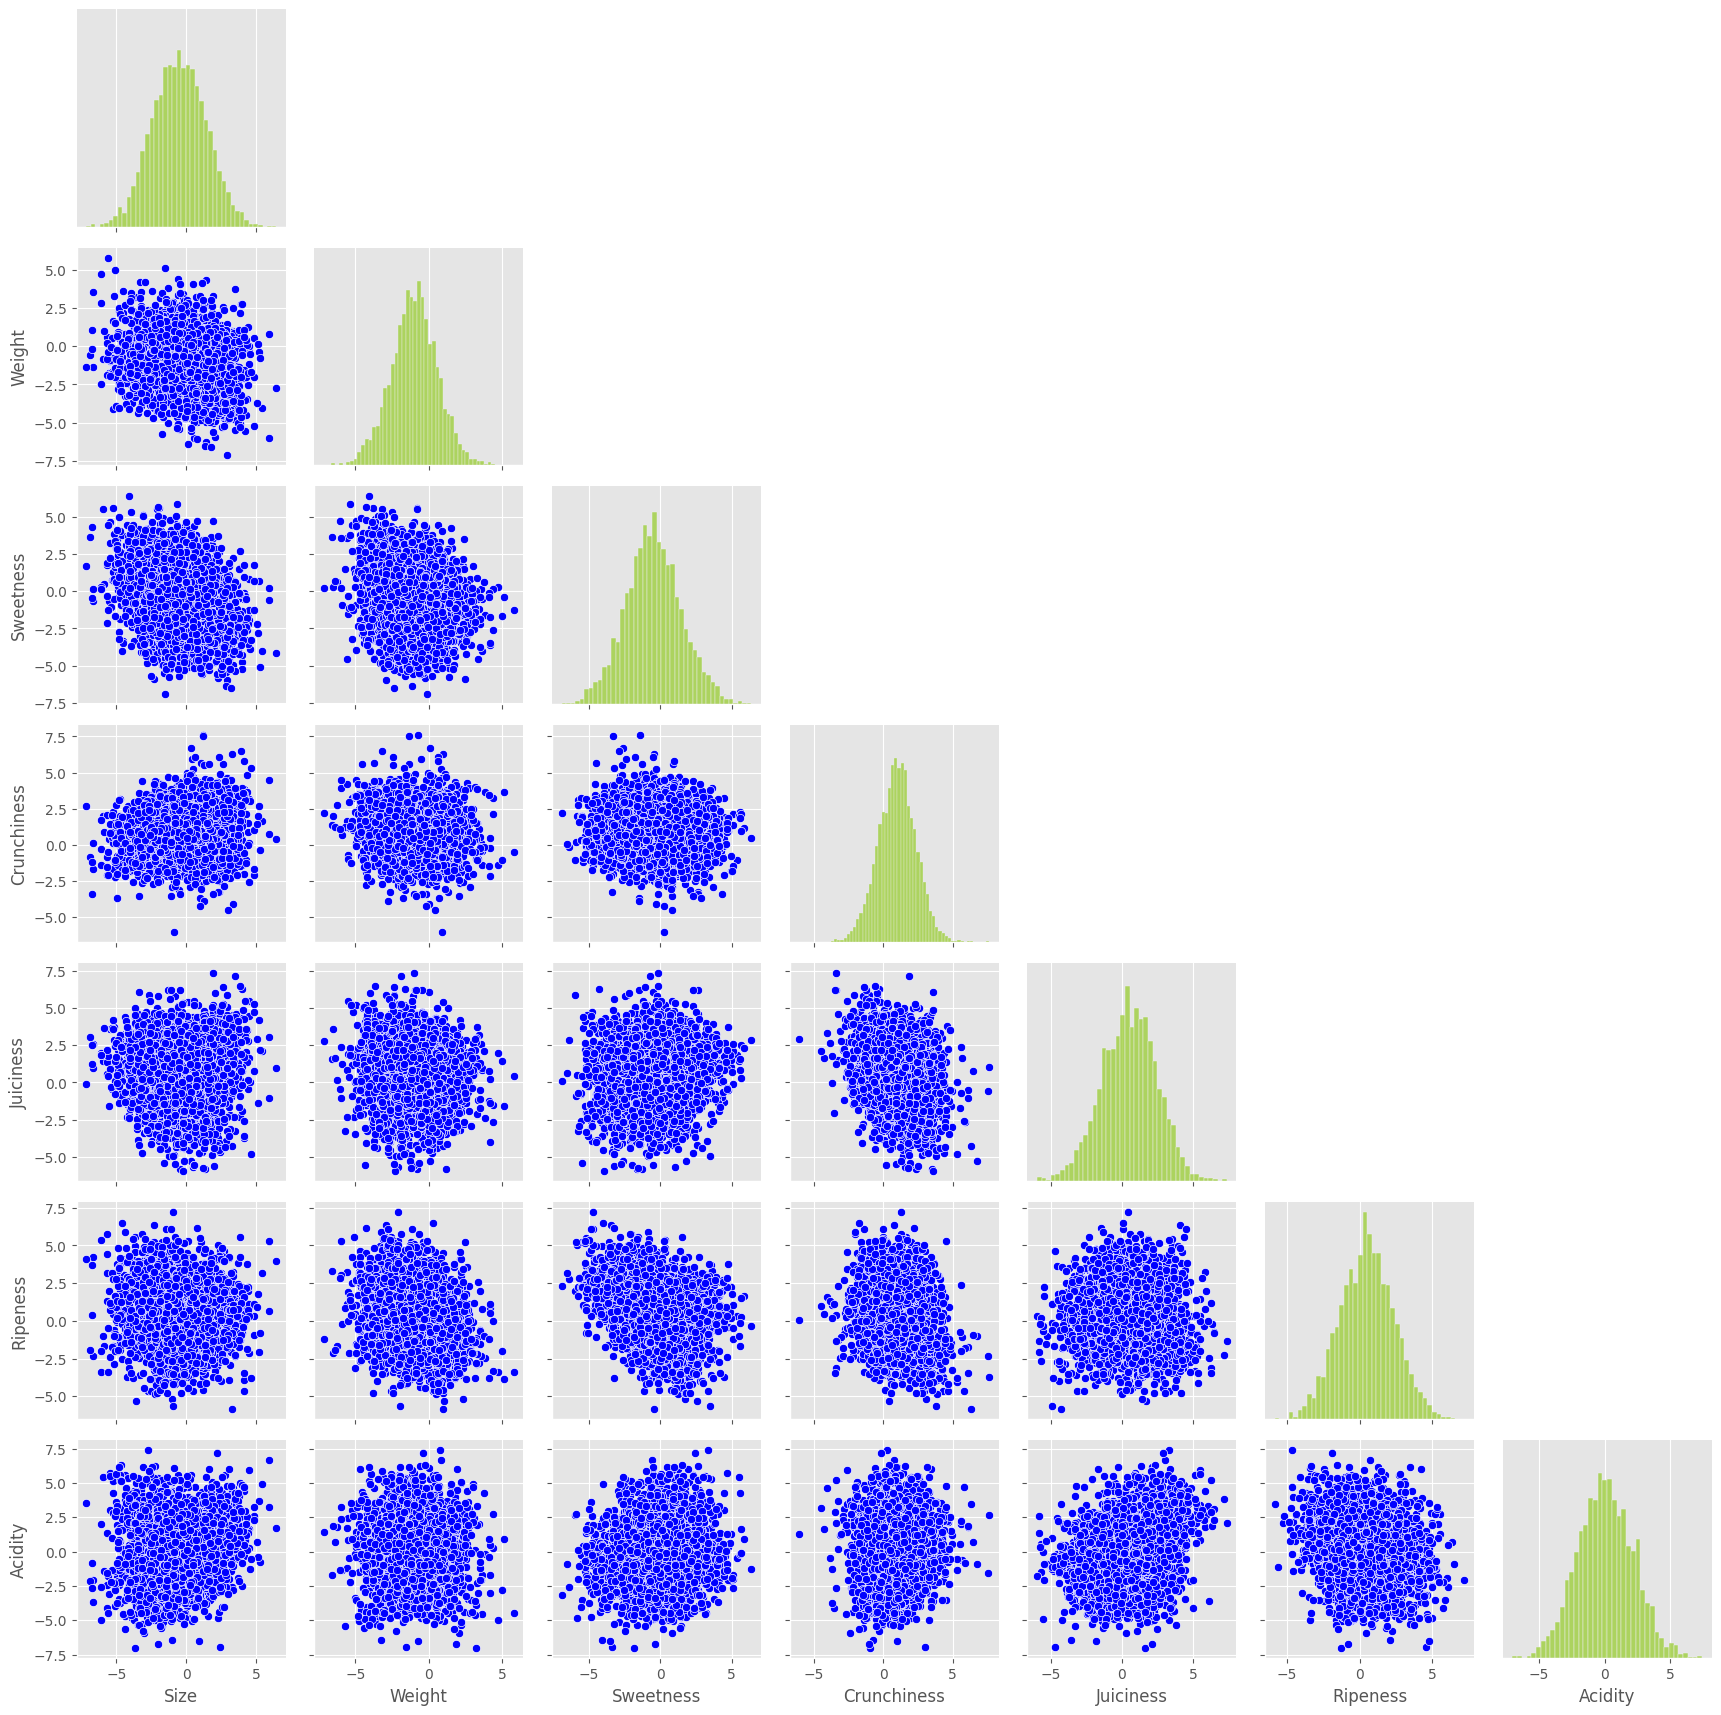

In [22]:
g = sns.PairGrid(data, corner = True)
g.map_lower(sns.scatterplot, color = 'blue')
g.map_diag(sns.histplot, color = 'yellowgreen')
g.fig.show()

According to the graph shown we can see that no pair of variables presents a correlation, we are going to create the correlation matrix, according to the result of the normality test, we only have 4 variables that come from a population with a Normal Distribution and the rest do not, so Therefore we will use a **`Spearman Correlation`**.

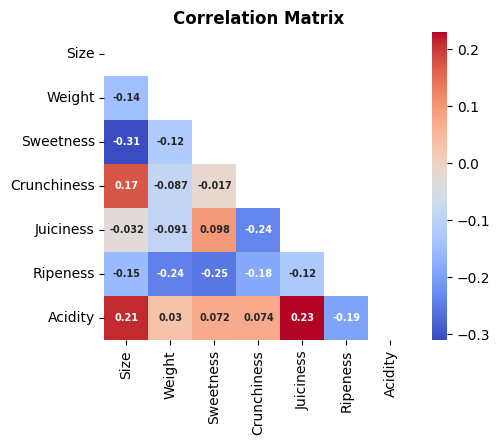

In [23]:
corr_matrix = data[cols].corr(method = 'spearman')
mask = np.triu(np.ones_like(corr_matrix, dtype = bool))

plt.figure(figsize = (5,4))
plt.style.use('default')
sns.heatmap(corr_matrix, cmap = 'coolwarm', annot = True, annot_kws = {'fontsize':7, 'fontweight':'bold'}, square = True, mask = mask)
plt.title("Correlation Matrix", fontsize = 12, fontweight = "bold")
plt.show()

According to the Correlation Matrix, no pair of variables presents a strong correlation to be taken into account.

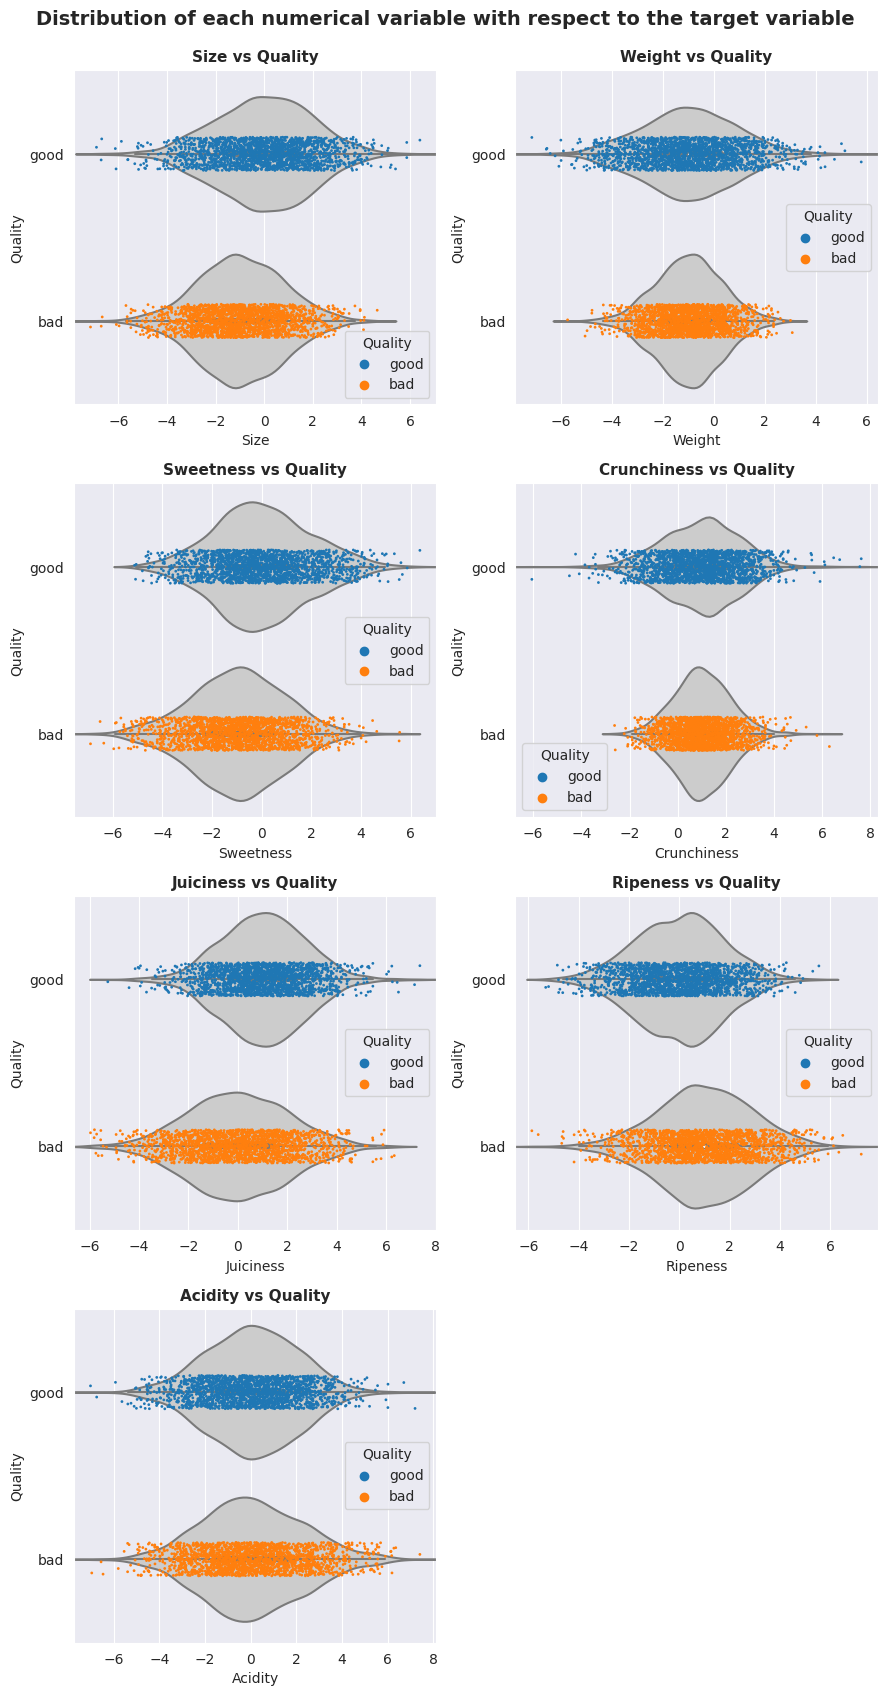

In [25]:
fig,axs = plt.subplots(nrows = 4, ncols = 2, figsize = (9,17))
sns.set_style('darkgrid')
axs = axs.flat

for i,col in enumerate(cols):
    sns.violinplot(data, x = col, y = 'Quality',color = '.8', ax = axs[i])
    sns.stripplot(data, x = col, y = 'Quality', size = 2, jitter  = 0.1, hue = 'Quality', ax = axs[i])
    axs[i].set_title(f'{col} vs Quality', fontsize = 11, fontweight = "bold")

fig.suptitle("Distribution of each numerical variable with respect to the target variable", fontsize = 14, fontweight = 'bold', y = 0.995)
fig.delaxes(ax = axs[7])
fig.tight_layout()
fig.show()

- **Multivariate Analysis**

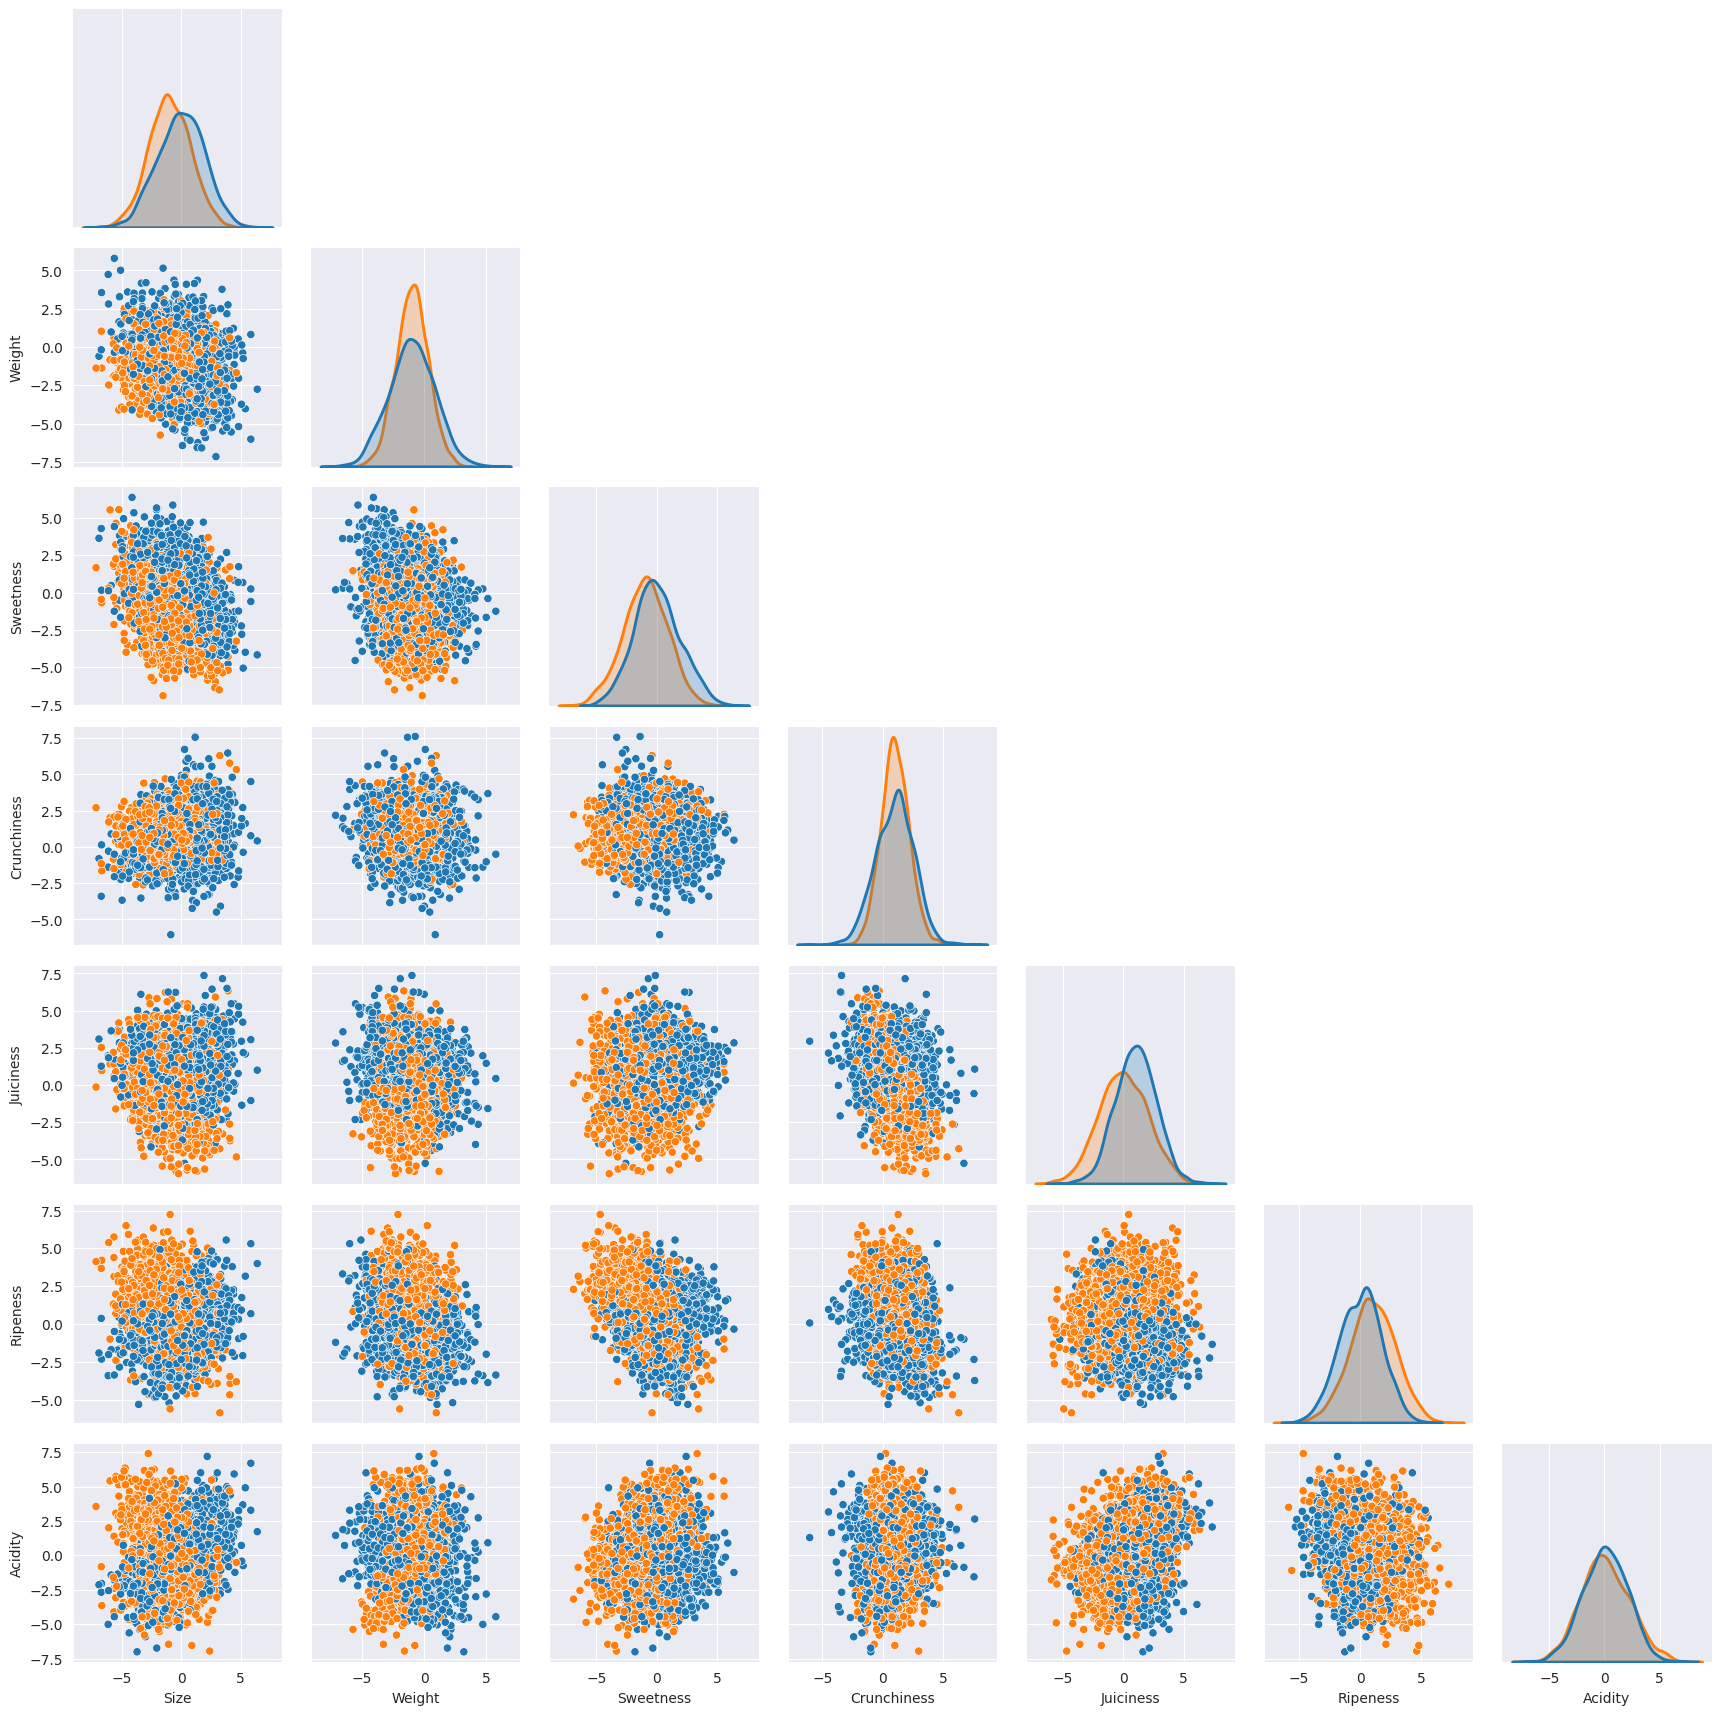

In [26]:
g = sns.PairGrid(data, hue = 'Quality', corner = True)
g.map_lower(sns.scatterplot)
g.map_diag(sns.kdeplot, fill = True, linewidth = 2.1)
g.fig.show()